In [1]:
!pip install bertopic==0.16.0 datasets==2.16.1 Arabic-Stopwords==0.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 52.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 17.6 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-

In [2]:
from datasets import load_dataset
import pandas as pd
import re
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

def clean_text(text: str):
    if not isinstance(text, str):
        # raise TypeError("text must be a string")
        return ""

    # remove urls
    text = re.sub(r"http\S+", " رابط ", text)

    # replace any digit with رقم
    text = re.sub(r"\d+", " رقم ", text)

    # set space before and after any punctuation
    text = re.sub(r"([^\w\s])", r" \1 ", text)

    # remove extra spaces
    text = re.sub(r"\s+", " ", text)

    # Remove any words that len = 1
    words = word_tokenize(text)
    text = " ".join([ w for w in words if len(w) > 1 ] )

    return text.lower().strip()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
ar_dataset = load_dataset("saudinewsnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/31030 [00:00<?, ? examples/s]

In [4]:
ar_dataset['train'][0]

{'source': 'aawsat',
 'url': 'http://aawsat.com/home/article/410826/بريطانيا-أربعة-محاور-لاستراتيجية-جديدة-تتصدى-للتطرف-على-مدى-خمس-سنوات',
 'date_extracted': '2015-07-21 02:51:32',
 'title': 'بريطانيا: أربعة محاور لاستراتيجية جديدة تتصدى للتطرف على مدى خمس سنوات',
 'author': 'لندن: رنيم حنوش',
 'content': 'حدد رئيس الوزراء البريطاني ديفيد كاميرون، اليوم (الاثنين)، ملامح استراتيجية للتصدي للتطرف داخل بريطانيا؛ وهي مسألة اعتبرها كاميرون "صراع جيلنا"، متعهدا خلال خطابه في مدينة بيرمنغهام بالتصدي لهؤلاء الذين ينشرون التطرف بين الشبان المسلمين البريطانيين.\n\n ورسم كاميرون الاطار العام لاستراتيجية مكافحة التطرف التي المقرر ان تنشر كاملة في وقت لاحق هذا العام، والتي تسعى للتصدي لانتشار الأفكار المتطرفة التي يروج لها متشددو تنظيم "داعش".\n\n وحسبما تناقلت وسائل الإعلام البريطانية، فإن خطة رئيس الوزراء ستكون على مدى خمسة أعوام للقضاء على التطرف الداخلي من خلال أربعة محاور، وهي: القضاء على إيديولوجية التطرف، والوقوف في وجه عمليات التجنيد وغسل الأدمغة بالأفكار المتطرفة، وإعادة اصوات الاسلام الم

In [5]:
raw_dataset = [
    {
        "text": rec["content"],
        "source": rec["source"],
        "date": rec["date_extracted"]
    }
    for rec in ar_dataset['train']
]

In [6]:
raw_dataset_df = pd.DataFrame( raw_dataset )
raw_dataset_df = raw_dataset_df.sample(frac=1, random_state=88)  # Shuffle

In [7]:
raw_dataset_df.head()

,text,source,date
13406,رفع الملياردير الكوري الجنوبي تشونج مون-جون و...,aleqtisadiya,2015-07-31 04:25:49
11540,عبر لاعبو فريق الاتحاد عن سعادتهم نظير أجواء م...,aawsat,2015-07-27 17:12:39
6792,عين اليوم – نجران\nأوضح أمين منطقة نجران المُ...,3alyoum,2015-07-24 16:04:55
6412,عين اليوم – متابعات\nقررت الحكومة الإسبانية ر...,3alyoum,2015-07-24 15:42:41
14447,أغلقت أمانة منطقة حائل عبر اللجنة الرباعية لل...,alweeam,2015-07-31 04:14:00


In [8]:
raw_dataset_df['text'] = raw_dataset_df['text'].apply(clean_text)

In [9]:
raw_dataset_df['text_len'] = raw_dataset_df['text'].apply(len)

In [10]:
raw_dataset_df.head(2)

,text,source,date,text_len
13406,رفع الملياردير الكوري الجنوبي تشونج مون جون وت...,aleqtisadiya,2015-07-31 04:25:49,3223
11540,عبر لاعبو فريق الاتحاد عن سعادتهم نظير أجواء م...,aawsat,2015-07-27 17:12:39,4118


<Axes: xlabel='text_len', ylabel='Count'>

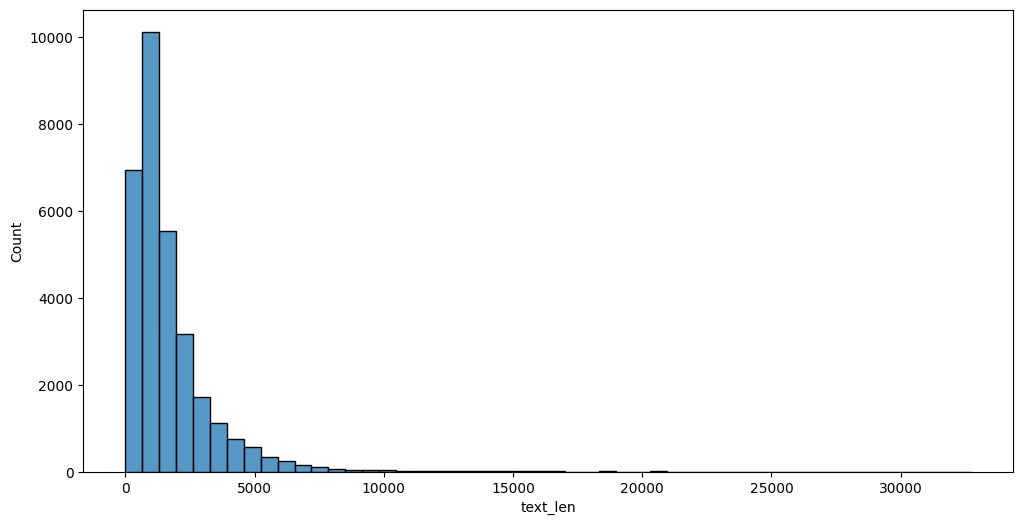

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(raw_dataset_df['text_len'], bins=50)

In [12]:
print(raw_dataset_df.shape)
raw_dataset_df = raw_dataset_df[ raw_dataset_df['text_len'] <= 10_000 ]
print(raw_dataset_df.shape)

(31030, 4)
(30902, 4)


In [13]:
print(raw_dataset_df.shape)
raw_dataset_df.drop_duplicates(['text'], inplace=True)
print(raw_dataset_df.shape)

(30902, 4)
(29691, 4)


In [14]:
raw_dataset_df['datetime_stamp'] = raw_dataset_df['date'].apply(lambda v: datetime.strptime(v, "%Y-%m-%d %H:%M:%S"))

raw_dataset_df['datetime_stamp'] = raw_dataset_df['datetime_stamp'].apply(lambda v: v.replace(hour=0, minute=0, second=0))

## Embedding

In [15]:
from sentence_transformers import SentenceTransformer

# model_id = "sentence-transformers/distiluse-base-multilingual-cased-v2"
model_id = "sentence-transformers/LaBSE"
embedding_model = SentenceTransformer(model_id, device="cuda:0")

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [16]:
news_embeddings = embedding_model.encode(raw_dataset_df['text'].values, show_progress_bar=True)

Batches:   0%|          | 0/928 [00:00<?, ?it/s]

In [17]:
news_embeddings.shape

(29691, 768)

## Dim Reduction

In [18]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=15,
                  min_dist=0.0, metric='cosine',
                  random_state=88)

## Clustering

In [19]:
from hdbscan import HDBSCAN

# A higher min_cluster_size will generate fewer topics
# A lower min_cluster_size will generate more topics.

hdbscan_model = HDBSCAN(min_cluster_size=50,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

## Vectorizer

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
import arabicstopwords.arabicstopwords as stp

stop_words = stp.stopwords_list()

vectorizer_model = CountVectorizer(min_df=3,
                                   stop_words=stop_words,
                                   analyzer='word',
                                   max_df=0.5,
                                   ngram_range=(1, 3)
                                   )

## Topic Representer



In [22]:
from bertopic.representation import KeyBERTInspired

keybert_model = KeyBERTInspired()

representation_model = {
    "KeyBERT": keybert_model
}

## Let's Go

In [23]:
from bertopic import BERTopic

topic_model = BERTopic(
    # Pipeline models
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,

    # Hyperparameters
    top_n_words=10,
    verbose=True
)

topics, probs =  topic_model.fit_transform(
    raw_dataset_df['text'].values,
    news_embeddings
)

2024-04-19 14:35:00,552 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-19 14:36:11,622 - BERTopic - Dimensionality - Completed ✓
2024-04-19 14:36:11,626 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
2024-04-19 14:36:17,638 - BERTopic - Cluster - Completed ✓
2024-04-19 14:36:17,651 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-19 14:37:36,918 - BERTopic - Representation - Completed ✓


In [24]:
print(
    raw_dataset_df['text'].values[50],
    topics[50], probs[50]
)

topic_model.get_topic(17)

فيما وصل عدد زوار مهرجان صيف حائل إلى نحو مليون زائر تتواصل الفعاليات المقامة تحت شعار `` صيفنا بكم أجمل `` في متنزه المغواة الترفيهي ومنتجع وحديقة السمراء وسلمى سيتي والحديقة مول وسلمى مول وسماح سنتر والتي انطلقت من ثاني أيام عيد الفطر المبارك وتستمر حتى نهاية شوال الجاري وأكد مدير إدارة الإعلام في أمانة منطقة حائل سعد الثويني أن الفعاليات والعروض مستمرة من خلال الفعاليات والفرق الترفيهية والمسابقات ومجلس المهرجان ومسرح الطفل والسوق الشعبي والحرف اليدوية وغيرها من الفعاليات المتنوعة الأخرى وأضاف أن زوار المهرجان هذا العام وصلوا إلى أكثر من مليون زائر في كافة المواقع التي تقام فيها الفعاليات إضافة إلى الحدائق والمتنزهات العامة مشيرا إلى أن الإقبال على العروض المسرحية والمجالس المستضيفة لنجوم الإعلام كان أكثر من جيد من قبل الجمهور كما أكد الثويني أن الفعاليات والعروض والمسرحيات التي نظمتها الأمانة شهدت إقبالا كبيرا من قبل قاطني حائل وزوارها الذين أبدوا إعجابهم بالفعاليات المقامة فيها متمنين استمرار بعضها على مدار العام وفي فترات متفاوتة ويتضمن برنامج صيف حائل عددا من الاحتفاليات المتنوع

[('الحفل', 0.021991155170044772),
 ('الخيرية', 0.017016718318960178),
 ('الأيتام', 0.012139943771719728),
 ('التطوعي', 0.010450400379254455),
 ('أهالي', 0.009665587467416154),
 ('التطوعية', 0.009618483576349195),
 ('الإعاقة', 0.008881832276856022),
 ('التنمية الاجتماعية', 0.008677040350413218),
 ('بعيد الفطر', 0.008432509999303294),
 ('تكريم', 0.007624917265462786)]

In [25]:
raw_dataset_df['topic'] = topics
raw_dataset_df['prob'] = probs

In [26]:
raw_dataset_df[ raw_dataset_df['topic'] == 17 ].head(10)

,text,source,date,text_len,datetime_stamp,topic,prob
18715,نظمت الندوة العالمية للشباب الإسلامي قافلة طبي...,alyaum,2015-08-03 20:31:23,495,2015-08-03,17,0.896875
1052,بحضور محافظ الأسياح سليمان البحيري وعدد من رؤس...,aljazirah,2015-07-21 12:33:50,694,2015-07-21,17,1.000000
2119,قام وكيل محافظة الاحساء خالد بن عبدالعزيز البر...,alyaum,2015-07-21 02:45:51,1662,2015-07-21,17,0.829954
10493,نظ مت لجنة التنمية الاجتماعية الأهلية بالبجادي...,aljazirah,2015-07-26 16:51:23,729,2015-07-26,17,0.918503
5940,نظمت بي أيه إي سيستمز السعودية للتطوير والتدري...,alwatan,2015-07-23 19:14:11,693,2015-07-23,17,1.000000
1792,قام فريق اترك أثر بإنتاج مقطع قصير من ضمن سلسل...,alweeam,2015-07-21 02:22:45,499,2015-07-21,17,1.000000
21436,كر محافظ حفر الباطن ورئيس اللجنة المنظمة العلي...,aljazirah,2015-08-06 18:42:24,885,2015-08-06,17,1.000000
1583,فاجأ فريق ابتسموا الاجتماعي والتطوعي المصلين ف...,alweeam,2015-07-21 02:17:32,1077,2015-07-21,17,1.000000
10237,أقامت لجنة التنمية الاجتماعية الأهلية في بني س...,aleqtisadiya,2015-07-26 17:15:05,668,2015-07-26,17,0.926729
7774,دعوة لاجتماع الجمعية الثلاثاء تعقد الجمعية الو...,alriyadh,2015-07-24 06:30:33,3312,2015-07-24,17,0.951478


In [27]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,10647,-1_داعش_النادي_القدم_الملك سلمان,"[داعش, النادي, القدم, الملك سلمان, الإرهاب, سل...","[الملك سلمان عبدالعزيز, سلمان عبدالعزيز آل, عب...",[تعقد جامعة نايف العربية للعلوم الأمنية والمنظ...
1,0,1749,0_النفط_أسعار_رقم رقم المائة_مليار,"[النفط, أسعار, رقم رقم المائة, مليار, رقم مليا...","[أسعار النفط, النفط, النفطية, الوقود, برميل يو...",[قال الأمين العام لـ أوبك عبد الله البدري للصح...
2,1,913,1_عدن_المقاومة_الحوثيين_الحوثي,"[عدن, المقاومة, الحوثيين, الحوثي, اليمن, المقا...","[عدن, الحوثيين وقوات, مطار عدن, محافظة عدن, ها...",[دكت طائرات التحالف بقيادة المملكة العربية الس...
3,2,748,2_يونايتد_الدوري_الموسم_مانشستر,"[يونايتد, الدوري, الموسم, مانشستر, سيتي, مدريد...","[تشيلسي, مانشستر يونايتد, مانشستر سيتي, الدوري...",[واصل مانشستر يونايتد سلسلة انتصاراته في بطولة...
4,3,631,3_اللاعبين_المعسكر_الودية_الفني,"[اللاعبين, المعسكر, الودية, الفني, الملعب, الت...","[تمارين, فترتين صباحية ومسائية, تدريبات, التدر...",[منيف الشهراني الرياض تقرر أن يلاقي فريق الهلا...
...,...,...,...,...,...,...
91,90,59,90_حرس_حرس الحدود_البحث والإنقاذ_والإنقاذ,"[حرس, حرس الحدود, البحث والإنقاذ, والإنقاذ, ال...","[فرق البحث والإنقاذ, البحث والإنقاذ, والإنقاذ,...",[باشرت فرق البحث والإنقاذ في قطاعات حرس الحدود...
92,91,57,91_الجمارك_تهريب_جمرك_رجال الجمارك,"[الجمارك, تهريب, جمرك, رجال الجمارك, مخبأة, مد...","[محاولة تهريب, مطار الملك عبدالعزيز, عبدالعزيز...",[إبراهيم الحذيفي عين اليوم تمكن رجال الجمارك ب...
93,92,53,92_رتبته_رتبته الجديدة_بترقيته_اللواء,"[رتبته, رتبته الجديدة, بترقيته, اللواء, رتبة, ...","[الأمير خالد الفيصل, الأمير فيصل بندر, الملكي ...",[الأمير فيصل بن بندر مقلدا الهيضل رتبته الجديد...
94,93,52,93_الحملة_السوريين_الوطنية السعودية_الأشقاء,"[الحملة, السوريين, الوطنية السعودية, الأشقاء, ...","[للأشقاء اللاجئين السوريين, اللاجئين السوريين,...",[أنهت الحملة الوطنية السعودية المرحلة الثالثة ...


In [28]:
topic_model.visualize_topics()

In [29]:
topic_model.visualize_heatmap()

In [30]:
topics_per_class = topic_model.topics_per_class(
    raw_dataset_df['text'].values,
    classes=raw_dataset_df['source'].values,
)

14it [00:26,  1.86s/it]


In [31]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=20)

In [32]:
topics_over_time = topic_model.topics_over_time(
    raw_dataset_df['text'].values,
    raw_dataset_df['datetime_stamp'].values
)

18it [02:06,  7.04s/it]


In [33]:
topic_model.visualize_topics_over_time(
    topics_over_time,
    topics=[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
)

In [34]:
hierarchical_topics = topic_model.hierarchical_topics(
    raw_dataset_df['text'].values
)

100%|██████████| 94/94 [00:01<00:00, 75.93it/s]


In [35]:
topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

## Topics Merging

In [36]:
topics_to_merge = [
    [15, 60, 4],
    [30, 23, 7]
]

topic_model.merge_topics(
    raw_dataset_df['text'].values,
    topics_to_merge
)

In [37]:
hierarchical_topics = topic_model.hierarchical_topics(
    raw_dataset_df['text'].values
)

topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

100%|██████████| 90/90 [00:01<00:00, 73.52it/s]


## Topics Filtering

In [38]:
raw_dataset_df.head()

,text,source,date,text_len,datetime_stamp,topic,prob
13406,رفع الملياردير الكوري الجنوبي تشونج مون جون وت...,aleqtisadiya,2015-07-31 04:25:49,3223,2015-07-31,41,0.996212
11540,عبر لاعبو فريق الاتحاد عن سعادتهم نظير أجواء م...,aawsat,2015-07-27 17:12:39,4118,2015-07-27,36,0.746488
6792,عين اليوم نجران أوضح أمين منطقة نجران الم هندس...,3alyoum,2015-07-24 16:04:55,601,2015-07-24,25,0.539681
6412,عين اليوم متابعات قررت الحكومة الإسبانية رفع ا...,3alyoum,2015-07-24 15:42:41,659,2015-07-24,0,0.623615
14447,أغلقت أمانة منطقة حائل عبر اللجنة الرباعية للت...,alweeam,2015-07-31 04:14:00,1972,2015-07-31,44,0.480915


In [39]:
filtered_raw_dataset_df = raw_dataset_df[ ~raw_dataset_df['topic'].isin([-1]) ]

## Inference

In [40]:
story = """
طرحت مؤسسة البترول الكويتية عطاءً؛ لبيع زيت وقود عالي الكبريت للتحميل في الفترة من فبراير/ شباط إلى إبريل/ نيسان.
وأوضحت مصادر تجارية، اليوم الخميس، أن المؤسسة تعرض شحنات من زيت الوقود عالي الكبريت تبلغ الواحدة 60 ألف طن لتحميلها من الكويت شهرياً بالفترة المذكورة.
"""

_topic, _prob =  topic_model.transform([story])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-04-19 14:43:53,447 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-04-19 14:44:13,448 - BERTopic - Dimensionality - Completed ✓
2024-04-19 14:44:13,449 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-04-19 14:44:13,454 - BERTopic - Cluster - Completed ✓


In [41]:
_topic, _prob

([0], array([1.]))

In [42]:
topic_model.get_topic(_topic[0])

[('النفط', 0.018606240535646995),
 ('أسعار', 0.016781011812792936),
 ('رقم رقم المائة', 0.01668004945576042),
 ('مليار', 0.014365067914482412),
 ('رقم مليار', 0.014238425779397957),
 ('الطاقة', 0.01272882205855667),
 ('بنسبة رقم رقم', 0.011994524170147925),
 ('رقم رقم مليار', 0.011688040587814953),
 ('سعر', 0.011573360683489334),
 ('رقم دولار', 0.010011245578350734)]

In [43]:
filtered_raw_dataset_df[ filtered_raw_dataset_df['topic'] == _topic[0] ].head()

,text,source,date,text_len,datetime_stamp,topic,prob
6412,عين اليوم متابعات قررت الحكومة الإسبانية رفع ا...,3alyoum,2015-07-24 15:42:41,659,2015-07-24,0,0.623615
20962,ارتفعت الأسهم الأوروبية في ختام التعاملات أمس ...,aleqtisadiya,2015-08-06 08:08:37,2762,2015-08-06,0,0.615315
6774,عين اليوم لندن تراجعت أسعار النفط اليوم الجمعة...,3alyoum,2015-07-24 16:03:58,1135,2015-07-24,0,1.000000
22905,إن كتاب قم بتعيين حارس ليس الكتاب الوحيد هذا ا...,alyaum,2015-08-06 01:39:09,2863,2015-08-06,0,0.610008
17285,أكد ماليون أن أثر دخول الأجانب سوق الأسهم لن ي...,alyaum,2015-08-02 23:38:50,2401,2015-08-02,0,0.959156


## Save and Reload

In [44]:
model_id = "sentence-transformers/LaBSE"
topic_model.save("/content/safe_bertopic", serialization="safetensors",
                 save_ctfidf=True, save_embedding_model=model_id)

loaded_model = BERTopic.load("/content/safe_bertopic")

In [ ]:
topic_model.save("/content/pickel_bert_topic_news.pkl", serialization="pickle")

loaded_model = BERTopic.load("/content/pickel_bert_topic_news.pkl")